<a href="https://colab.research.google.com/github/Mo-Harb569/A-simple-system-that-simulates-the-work-of-barber-shops/blob/main/Transfer_Teeth_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout
from sklearn.utils import class_weight
from tensorflow.keras import losses
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from sklearn.utils import class_weight
from sklearn.utils import class_weight


In [ ]:


from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/Teeth DataSet.zip" -d "/content/New_Data_EX8"


Archive:  /content/drive/MyDrive/Teeth DataSet.zip
replace /content/New_Data_EX8/Teeth_Dataset/Testing/OC/oc_1239_0_6735.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: /content/New_Data_EX8/Teeth_Dataset/Testing/output_image.jpg  
  inflating: /content/New_Data_EX8/Teeth_Dataset/Testing/outputs/a_81_0_9781.jpg  
  inflating: /content/New_Data_EX8/Teeth_Dataset/Testing/outputs/a_86_0_774.jpg  
  inflating: /content/New_Data_EX8/Teeth_Dataset/Testing/outputs/a_81_0_9451.jpg  
  inflating: /content/New_Data_EX8/Teeth_Dataset/Testing/outputs/a_81_0_2986.jpg  
  inflating: /content/New_Data_EX8/Teeth_Dataset/Testing/outputs/a_151_0_6880.jpg  
  inflating: /content/New_Data_EX8/Teeth_Dataset/Testing/outputs/a_126_0_9339.jpg  
  inflating: /content/New_Data_EX8/Teeth_Dataset/Testing/outputs/a_151_0_6976.jpg  
  inflating: /content/New_Data_EX8/Teeth_Dataset/Testing/outputs/a_80_0_8374.jpg  
  inflating: /content/New_Data_EX8/Teeth_Dataset/Testing/outputs/a_152_0_7749.jpg  
  inflat

In [ ]:
!rm -r /content/New_Data_EX8/Teeth_Dataset/Testing/out
!rm -r /content/New_Data_EX8/Teeth_Dataset/Testing/output
!rm -r /content/New_Data_EX8/Teeth_Dataset/Testing/outputs
!rm -r /content/New_Data_EX8/Teeth_Dataset/Testing/output_image.jpg

In [ ]:
train_data = "/content/New_Data_EX8/Teeth_Dataset/Training"
test_data = "/content/New_Data_EX8/Teeth_Dataset/Testing"
validation_data = "/content/New_Data_EX8/Teeth_Dataset/Validation"


In [ ]:

img_width = 224
img_height = 224
batch_size = 32

In [ ]:
class_names = sorted(os.listdir(train_data))
num_classes = len(class_names)
print(f"Number of classes detected: {num_classes}")
print(f"Class names: {class_names}")
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)
print("Training data loaded successfully with tf.data.Dataset.")


Number of classes detected: 7
Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Found 3087 files belonging to 7 classes.
Training data loaded successfully with tf.data.Dataset.


In [ ]:
print("\nActual CLASS_NAMES order from training dataset:")
print(train_ds_raw.class_names)


Actual CLASS_NAMES order from training dataset:
['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [ ]:
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    validation_data,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    seed=123
)
print("Validation data loaded successfully with tf.data.Dataset.")

Found 1028 files belonging to 7 classes.
Validation data loaded successfully with tf.data.Dataset.


In [ ]:
test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_data,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    seed=123
)
print("Testing data loaded successfully with tf.data.Dataset.")

Found 1028 files belonging to 7 classes.
Testing data loaded successfully with tf.data.Dataset.


In [ ]:
class_names = sorted(os.listdir(train_data))
num_classes = len(class_names)

num_classes

7

In [ ]:
print(f"\n detected classes  {class_names}")
print(f"Number of categories {num_classes}")



 detected classes  ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Number of categories 7


In [ ]:
#تحسين الاداء ب استخدام (Prefetching)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataset prefetching (Prefetching) applied.")


Dataset prefetching (Prefetching) applied.


In [ ]:
#Calculate class weights
print("\n Step 2.1: Calculating Class Weights...")

all_labels_integer = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in train_ds_raw], axis=0)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels_integer),
    y=all_labels_integer
)

class_weights_dict = dict(enumerate(class_weights))

print(f"\nClass weights calculated successfully:")
for i, weight in class_weights_dict.items():
    print(f"  Class {class_names[i]} (ID: {i}): Weight {weight:.2f}")

print("\nStep 2.1: Class Weights Calculation - Completed successfully!")


 Step 2.1: Calculating Class Weights...

Class weights calculated successfully:
  Class CaS (ID: 0): Weight 0.92
  Class CoS (ID: 1): Weight 0.98
  Class Gum (ID: 2): Weight 1.23
  Class MC (ID: 3): Weight 0.82
  Class OC (ID: 4): Weight 1.36
  Class OLP (ID: 5): Weight 0.82
  Class OT (ID: 6): Weight 1.12

Step 2.1: Class Weights Calculation - Completed successfully!


In [ ]:
from tensorflow.keras import models

In [ ]:
#Build model using ResNet50V2

import tensorflow as tf
from tensorflow.keras import layers, models # تأكد من استيراد models و layers


base_model = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
print("ResNet50V2 base model loaded.")

base_model.trainable = True


ResNet50V2 base model loaded.


In [ ]:
 # تعريف طبقة Data Augmentation (إثراء البيانات)
data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.2),
      tf.keras.layers.RandomContrast(0.2),
      tf.keras.layers.RandomBrightness(0.2),
])

model = models.Sequential([
      data_augmentation, # طبقة إثراء البيانات

      # layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input), #هاض السطر جمدته لانه عملي مشكله ادخال بس غيرت الموديل
      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.4),
      layers.Dense(7, activation='softmax')
])
print("Model built successfully.")

Model built successfully.


In [ ]:
from tensorflow.keras import layers, models, optimizers, losses


In [ ]:

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001 ),
    loss=losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)
print("Model compiled successfully.")



Model compiled successfully.


In [ ]:

print("\nModel Summary:")
model.summary()



Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
#Fit Model


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Teeth_Model_Checkpoints_ResNet50V2'
#هون انا حددت الباث الي رح احفظ فيه افضل نسخ من الموديل تبعي

os.makedirs(checkpoint_dir, exist_ok=True)
#ههذ الامر من او اس بنشآ ملف بنفس الاسم الي انا اعطيته ياه اكزيت ترو يعني اذا موجود تعطيش ايرور عادي كمل

In [ ]:
checkpoint_filepath = os.path.join(checkpoint_dir, 'best_efficientnetb0_teeth_model.keras')
#best_efficientnetb0_teeth_model.keras اسم افضل نسخه من الموديل
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    #المكان الي رح احفظ فيه الموديل
    save_weights_only=False,
    #يعني احفظلي الموديل كله مش بس الاوزان تبعته
    monitor='val_accuracy',
    mode='max',
    #هاي يعني كل ما زادت ال val_acc بكون احسن خذها
    save_best_only=True,
    #يعني احفظلي الموديل بس في حاله اذا كان احسن من الي قبله
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

epochs = 40

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[model_checkpoint_callback, early_stopping_callback],
    class_weight=class_weights_dict
    #درب مع مراعاه ال اوزان الي عملناها
)

print("\nStep 3: Model Training - Completed successfully!")


Epoch 1/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.1446 - loss: 2.2995
Epoch 1: val_accuracy improved from -inf to 0.20136, saving model to /content/drive/MyDrive/Teeth_Model_Checkpoints_ResNet50V2/best_efficientnetb0_teeth_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 107s 659ms/step - accuracy: 0.1447 - loss: 2.2987 - val_accuracy: 0.2014 - val_loss: 1.9161
Epoch 2/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.1951 - loss: 2.0198
Epoch 2: val_accuracy improved from 0.20136 to 0.33658, saving model to /content/drive/MyDrive/Teeth_Model_Checkpoints_ResNet50V2/best_efficientnetb0_teeth_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 59s 487ms/step - accuracy: 0.1952 - loss: 2.0196 - val_accuracy: 0.3366 - val_loss: 1.7698
Epoch 3/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.2190 - loss: 1.9289
Epoch 3: val_accuracy improved from 0.33658 to 0.42023, saving model to /content/drive/MyDrive/Teeth_Model_Checkpoints_ResNet50V2/best_efficientnetb0_teeth_model.keras
97/9

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9929 - loss: 0.0286

Final Test Loss: 0.0541
Final Test Accuracy: 0.9874


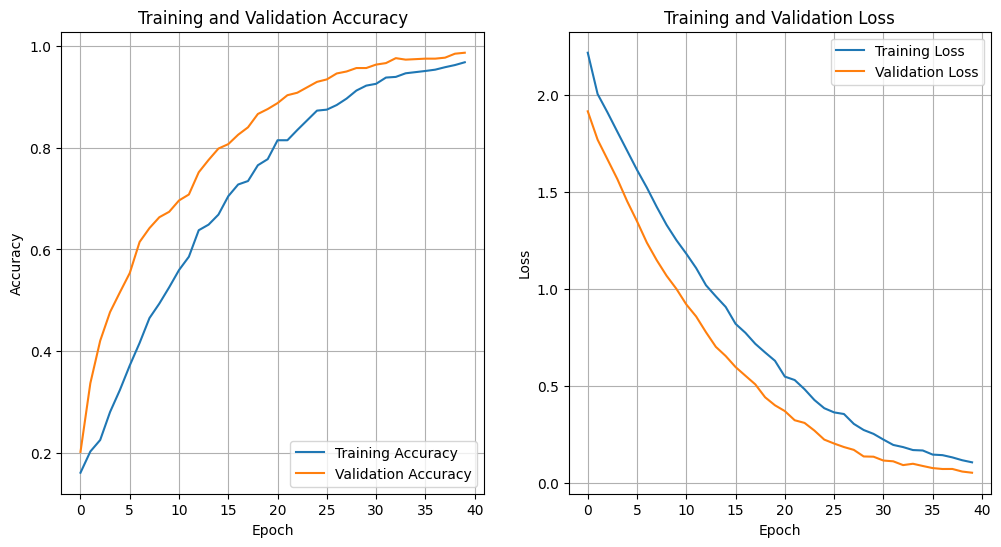

In [ ]:
#Evaluate model

import matplotlib.pyplot as plt
import tensorflow as tf


test_results = model.evaluate(test_ds)

test_loss = test_results[0]
test_accuracy = test_results[1]

print(f"\nFinal Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

if 'history' in locals() and history is not None:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.show()
else:
    print("Warning: Training history ('history') not found. Unable to plot.  ensure Step 3.2 was run correctly.")


In [ ]:
#test acc on train data

print("\nEvaluating accuracy on training data (train_ds)")
train_loss, train_accuracy = model.evaluate(train_ds, verbose=1)
print(f"Training Accuracy: {train_accuracy:.4f}")


Evaluating accuracy on training data (train_ds)
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9939 - loss: 0.0243
Training Accuracy: 0.9932


In [ ]:
#test acc in test data
print("\nEvaluating accuracy on test data (test_ds)")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")


Evaluating accuracy on test data (test_ds)
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9929 - loss: 0.0286
Test Accuracy: 0.9874


In [ ]:
#Saving the final  model

final_model_save_path = os.path.join(checkpoint_dir, 'final_teeth_classification_model.keras')

try:
    model.save(final_model_save_path)
    print(f"Final model saved successfully to: {final_model_save_path}")
except Exception as e:
    print(f"Error saving the final model: {e}")
    print("Please ensure your Google Drive has enough space and is mounted correctly.")

print("\nStep : Saving the Final Model - Completed successfully!")

Final model saved successfully to: /content/drive/MyDrive/Teeth_Model_Checkpoints_ResNet50V2/final_teeth_classification_model.keras

Step : Saving the Final Model - Completed successfully!


In [ ]:
#Streamlit code
print("\nStep : Writing the Streamlit Application Code")
streamlit_app_code = """
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import os

# --- Configuration for your App ---
IMG_HEIGHT = 224
IMG_WIDTH = 224

CLASS_NAMES = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
#هون رح ابعثله باث الموديل الي انا حفظته
MODEL_PATH = '/content/drive/MyDrive/Teeth_Model_Checkpoints_ResNet50V2/final_teeth_classification_model.keras'

#هسا هون بدي احمل ال trained model
@st.cache_resource
def load_my_model():
    try:
        model = tf.keras.models.load_model(MODEL_PATH)
        return model
    except Exception as e:
        st.error(f"Error loading the model. Make sure '{MODEL_PATH}' is correct and accessible.")
        st.error(f"Error details: {e}")
        return None

my_model = load_my_model()

#هون كود التوقعات
def make_prediction(image_input):
    if my_model is None:
        return "Model not loaded.", 0.0

    img = Image.open(image_input).convert('RGB')
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension (1 image)

    processed_img = tf.keras.applications.resnet_v2.preprocess_input(img_array)

    st.sidebar.subheader("Debugging Info (Preprocessed Image)")
    st.sidebar.write(f"Shape of processed_img: {processed_img.shape}")
    st.sidebar.write(f"Data type of processed_img: {processed_img.dtype}")
    st.sidebar.write(f"Min pixel value: {np.min(processed_img):.4f}")
    st.sidebar.write(f"Max pixel value: {np.max(processed_img):.4f}")

    predictions = my_model.predict(processed_img)
    predicted_probabilities = predictions[0]

    predicted_class_id = np.argmax(predicted_probabilities)
    predicted_class_name = CLASS_NAMES[predicted_class_id]
    confidence = predicted_probabilities[predicted_class_id] * 100

    return predicted_class_name, confidence

st.set_page_config(
    page_title="Dental diseases classifier",
    page_icon="🦷",
    layout="centered"
)

st.title("🦷 Dental Image Classifier")
st.markdown("Upload a dental image and let the model predict the condition.")

if my_model is None:
    st.warning("Model could not be loaded. Please fix the path and restart the app.")
else:
    uploaded_file = st.file_uploader("Choose an image file...", type = ["jpg", "jpeg", "png", "bmp", "gif", "tiff", "tif", "webp", "heif", "heic", "svg"])

    if uploaded_file is not None:
        st.image(uploaded_file, caption='Uploaded Image', use_column_width=True)
        st.write("---")

        with st.spinner('Classifying image...'):
            class_name, confidence = make_prediction(uploaded_file)

        if class_name != "Model not loaded.":
            if confidence < 50.0:
                st.warning(f"**Low Confidence Prediction: {class_name}**")
                st.warning(f"Confidence: {confidence:.2f}% (Model is not very certain, result may be unreliable)")
            else:
                st.success(f"**Prediction: {class_name}**")
                st.info(f"Confidence: {confidence:.2f}%")
        else:
            st.error(class_name)

st.markdown("---")
st.markdown("App created with Streamlit and TensorFlow .")
st.markdown("Developer is Mohammad Harb intern ship in cellula teck")
"""
streamlit_app_file_path = os.path.join(checkpoint_dir, "app.py")

with open(streamlit_app_file_path, "w") as f:
    f.write(streamlit_app_code)

print(f"Streamlit app code saved as: {streamlit_app_file_path}")
print("straemlit built Completed successfully")



Step : Writing the Streamlit Application Code
Streamlit app code saved as: /content/drive/MyDrive/Teeth_Model_Checkpoints_ResNet50V2/app.py
straemlit built Completed successfully


In [ ]:

!pip install pyngrok

In [ ]:
!pip install streamlit

In [ ]:
# ngrokهون من خلال تقنيه
#قدرت اشغل تطبيقي ال stramlit

from pyngrok import ngrok
#من خلال ال ngroc قدرت اعمل نفق عشان اوصل التطبيق تبعي ع النت

import os
import subprocess
#هاي المكتبه بتخليني اشتغل على اوامر زي التيرمنال ع كود بايثون
import time
# ngrokمن هون بجيب هاي المكتبه عشان اوقف الكود ثواني قليله عشان اعطي ستريم ليت وقت كافي يشتغل قبل ما نحاول نربط فيه ngrok

NGROK_AUTH_TOKEN = "2zhY6b8SyWCiwYUTl0sXTqvDBOQ_7YWaT86DrVdFYUWWz1J87"
#بجيبه من الموقع

if NGROK_AUTH_TOKEN == "YOUR_NGROK_AUTH_TOKEN_HERE":
    # هاي اذا الرابط تبعي اذا تحقق والرابط وجود بنزل ع الكود تحت وبنفذ
    print("Error: Please get your ngrok Auth Token from https://ngrok.com/dashboard/your-authtoken and replace 'YOUR_NGROK_AUTH_TOKEN_HERE' in the code.")
else:
    try:
        ngrok.set_auth_token(NGROK_AUTH_TOKEN)
        print("Authentication of ngrok successful.")
    except Exception as e:
        print(f"Error authenticating ngrok: {e}")
        print("Please check your ngrok Auth Token again.")

    streamlit_app_file_path = os.path.join(checkpoint_dir, 'app.py')

    if not os.path.exists(streamlit_app_file_path):
        print(f"Error: Streamlit app file not found at the specified path: {streamlit_app_file_path}.  ensure you have run Step 6.2 correctly again.")
    else:
        #بدء تشيغيل ستريم ليت
        print(f"Starting Streamlit application: {streamlit_app_file_path}")
        #هاض الامر الي بشغل تطبيق ستريم ليت فعليا
        process = subprocess.Popen(
            ["streamlit", "run", streamlit_app_file_path, "--server.port", "8501", "--server.enableCORS", "false"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        print("start run app streamlit in the background")

        #print(هسا بدنا نبلش نعمل ربط ngrok , streamlit)

        try:
            time.sleep(5)

            public_url = ngrok.connect(8501).public_url
            print(f"\nYour Streamlit application is now running at: {public_url}")
            print("\nPlease click the link above to open the application in your browser.")
            print("To stop the application, you must stop the execution of this cell in Google Colab (by clicking the stop button).")
        except Exception as e:
            print(f"Error creating ngrok tunnel: {e}")
            print("Please check your ngrok Auth Token in the previous step and ensure Streamlit started correctly.")
            print("If you see a 'Your account is limited to 1 tunnel' message, you might have multiple active tunnels. You can disconnect previous tunnels from the ngrok dashboard or by running ngrok.kill() if possible.")


Authentication of ngrok successful.
Starting Streamlit application: /content/drive/MyDrive/Teeth_Model_Checkpoints_ResNet50V2/app.py
start run app streamlit in the background

Your Streamlit application is now running at: https://f8c75fdbfe22.ngrok-free.app

Please click the link above to open the application in your browser.
To stop the application, you must stop the execution of this cell in Google Colab (by clicking the stop button).


In [ ]:
from pyngrok import ngrok
ngrok.kill()
print("All ngrok tunnels have been killed.")
#هاض الكود عشان اسكر كل التنلز تبعون انجروك الي بصيروا بس افتح كثير


All ngrok tunnels have been killed.


In [ ]:
import os

model_path_to_check = '/content/drive/MyDrive/Teeth_Model_Checkpoints_ResNet50V2/final_teeth_classification_model.keras'

if os.path.exists(model_path_to_check):
    print(f"Success: The model file exists at: {model_path_to_check}")
    print(f"File size: {os.path.getsize(model_path_to_check) / (1024 * 1024):.2f} MB")
else:
    print(f"Error: The model file DOES NOT exist at: {model_path_to_check}")
    print("Please ensure:")
    print("1. Your Google Drive is mounted correctly.")
    print("2. You have run 'Step 6.1: Saving the Final Model' successfully and without errors.")
    print("3. The path in 'Step 6.1' matches this path exactly.")

# Check if Google Drive is mounted
if not os.path.exists('/content/drive'):
    print("\nWarning: Google Drive is not mounted. Please mount it by running the Google Drive mounting cell.")
elif not os.path.exists('/content/drive/MyDrive'):
    print("\nWarning: MyDrive not found. Check Google Drive mounting permissions.")


Success: The model file exists at: /content/drive/MyDrive/Teeth_Model_Checkpoints_ResNet50V2/final_teeth_classification_model.keras
File size: 276.52 MB


In [ ]:
import tensorflow as tf
import os

model_path_to_load = '/content/drive/MyDrive/Teeth_Model_Checkpoints_ResNet50V2/final_teeth_classification_model.keras'

print(f"Attempting to load model from: {model_path_to_load}")

try:
    loaded_model = tf.keras.models.load_model(model_path_to_load)
    print("\nSuccess: Model loaded successfully in a separate cell!")
    loaded_model.summary()
except Exception as e:
    print(f"\nError: Failed to load model in a separate cell. Details: {e}")
    print("This indicates a potential issue with the saved model file itself or TensorFlow's ability to deserialize it.")


#تاكد اني متصل لسا بالدرايف تبعي
if not os.path.exists('/content/drive/MyDrive'):
    print("\nWarning: Google Drive (MyDrive) is not mounted or accessible. Please ensure it's mounted.")


Attempting to load model from: /content/drive/MyDrive/Teeth_Model_Checkpoints_ResNet50V2/final_teeth_classification_model.keras

Success: Model loaded successfully in a separate cell!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,278,551 (275.72 MB)

 Trainable params: 24,077,703 (91.85 MB)

 Non-trainable params: 45,440 (177.50 KB)

 Optimizer params: 48,155,408 (183.70 MB)